# 121_feature_importance.ipynb
Runs feature importance algorithm for the given model.

In [1]:
from pathlib import Path
path = Path.cwd().parent.parent

# Setup parameters for each type of simulation
SETUP = {'PC1': {'X': path / "data" / "interim" / "pc_by_feature_group_for_patients.csv",
                 'hyperparameters_file' : path / "notebooks" / "modeling" / "optimal_params_pc1.json"},
        'PC1_3' : {'X' : path / "data" / "interim" / "pc1_to_3_by_feature_group_for_patients.csv",
                   'hyperparameters_file' : path / "notebooks" / "modeling" / "optimal_params_pc1_to_3.json"},
        'ALL_IMG' : {'X' : path / "data" / "raw" / "imagingFeatures.csv",
                     'hyperparameters_file' : path / "notebooks" / "modeling" / "optimal_params_all_image_features.json"}}

# Each of the models uses a different input- so choose the model that we would like
# to run for this chosen version
MODEL = 'ALL_IMG'

# What we would like to predict
TARGET = 'Mol Subtype'

In [ ]:
# Factors: PC1 for each of the ten feature groups
# Predictor: Molecular Subtype
import pandas as pd
from sklearn.preprocessing import LabelEncoder

trainPatientID = (pd.read_csv(path / "data" / "processed" / "trainDataPatientID.csv")
                  .drop(['Unnamed: 0'], axis=1)
                  .rename(columns={'Patient.ID' : 'Patient ID'}, errors='ignore'))
testPatientID = (pd.read_csv(path / "data" / "processed" / "testDataPatientID.csv")
                  .drop(['Unnamed: 0'], axis=1)
                  .rename(columns={'Patient.ID' : 'Patient ID'}, errors='ignore'))

# Fetch the feature data
features = pd.read_csv(SETUP[MODEL]['X'])
features.rename(columns={'Patient.ID': 'Patient ID'}, inplace=True, errors='ignore')

# Fetch the outcome data
clin = pd.read_csv(path / "data" / "raw" / "clinicalData_clean.csv")

# Merge feature with relevant outcome
data = features.merge(clin[['Patient ID', TARGET]], on='Patient ID', how='inner')
data = data.drop('Unnamed: 0', axis=1, errors='ignore')

# Select only the desired outcome, convert to factor if needed
y = data[[TARGET, 'Patient ID']]
if y[TARGET].dtype == 'object' or y[TARGET].dtype.name == 'category':
    le = LabelEncoder()
    y[TARGET] = le.fit_transform(y[TARGET])

# Currently, y has Patient ID and TARGET
# Select only the test/train and the TARGET column
yTrain = y[y['Patient ID'].isin(trainPatientID['Patient ID'])][TARGET]
yTest = y[y['Patient ID'].isin(testPatientID['Patient ID'])][TARGET]

# Select only the relevant patients and remove the target
XTrain = (data[data['Patient ID'].isin(trainPatientID['Patient ID'])]
          .drop(['Patient ID', TARGET], axis=1))
XTest = (data[data['Patient ID'].isin(testPatientID['Patient ID'])]
         .drop(['Patient ID', TARGET], axis=1))

In [17]:
# Fetch the optimal hyperparameters for this model
import json
with open(SETUP[MODEL]['hyperparameters_file'], 'r') as file:
    model_info = json.load(file)

for model in model_info:
    if model['model'] == 'RandomForest':
        best_rf_params = model['best_params']

best_rf_params

{'bootstrap': True,
 'max_depth': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 500}

## Permutation importance by feature group
* Used to determine how much a model's performance relies on each feature
* Works by shuffling the values of a feature and observing the impact on the model's error rate
* A large increase in the error while shuffling indicates the feature is important, while little to no change suggests that it is not

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(**best_rf_params)
rf.fit(XTrain, yTrain)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, n_estimators=500)

In [19]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance
result = permutation_importance(
    rf, XTest, yTest,
    n_repeats=10, # number of times to shuffle each feature
    random_state=42,
    n_jobs=-1 # use all CPU cores
)

In [21]:
# Get feature names
feature_names = X.columns

# Create a DataFrame for easy viewing
importances_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': result.importances_mean, # average drop in accuracy when the feature is shuffled
    'importance_std': result.importances_std # standard deviation across repeats
}).sort_values(by='importance_mean', ascending=False)

print(importances_df)

                                               feature  importance_mean  \
468  SER_map_information_measure_correlation1_tissu...         0.008140   
480                 PE_map_Correlation2_tissue_PostCon         0.005814   
521  WashinRate_map_information_measure_correlation...         0.005814   
370                     SER_map_Correlation1_tissue_T1         0.005814   
282                        SER_Washout_tumor_vol_cu_mm         0.005814   
..                                                 ...              ...   
174  Grouping_based_variance_of_washin_slope_3D_tis...         0.000000   
173  Grouping_based_variance_of_washin_slope_3D_tis...         0.000000   
172  Grouping_based_mean_of_washin_slope_3D_tissue_...         0.000000   
171  Grouping_based_mean_of_washin_slope_3D_tissue_...         0.000000   
528             WashinRate_map_kurtosis_tissue_PostCon         0.000000   

     importance_std  
468        0.002848  
480        0.000000  
521        0.000000  
370        

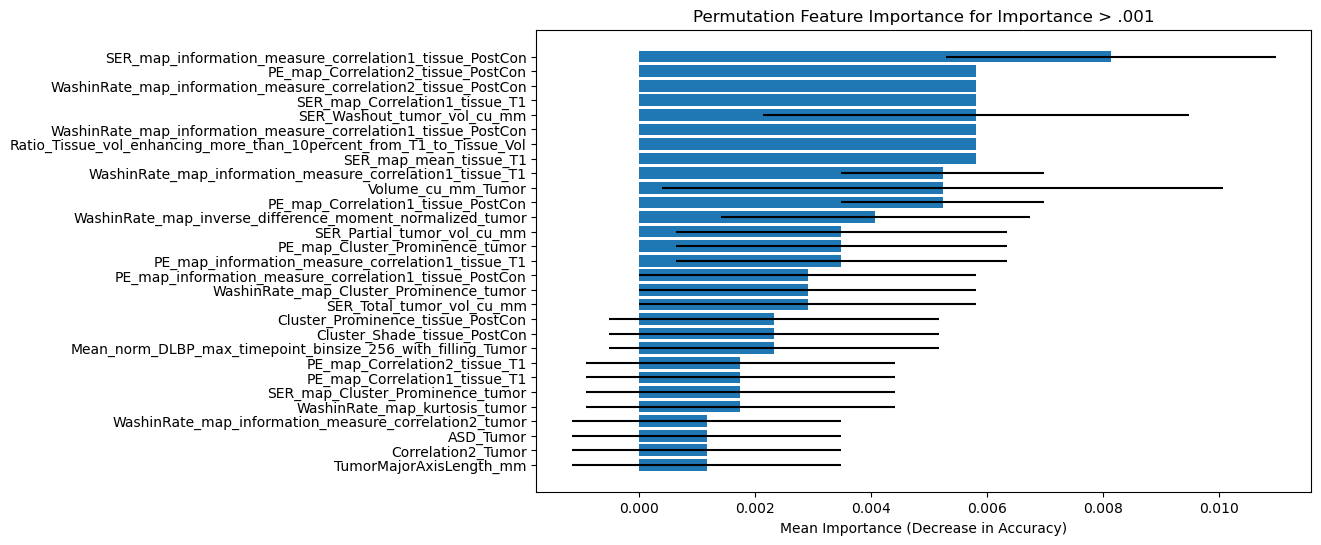

In [25]:
import matplotlib.pyplot as plt

important = importances_df[importances_df['importance_mean'] > .001]

plt.figure(figsize=(10,6))
plt.barh(important['feature'], important['importance_mean'], xerr=important['importance_std'])
plt.xlabel('Mean Importance (Decrease in Accuracy)')
plt.title('Permutation Feature Importance for Importance > .001')
plt.gca().invert_yaxis()
plt.show()